Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, нашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Шаг 1. Загрузка данных**

In [1]:
!pip install phik -q
!pip install shap -q
!pip install -U scikit-learn

In [2]:
# загружаем необходимые библиотеки, модели, метрики

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
import phik
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     GridSearchCV)
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   LabelEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
# Загрузка данных
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [4]:
display(market_file.head())
display(market_money.head())
display(market_time.head())
display(money.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [5]:
# приведем название колонок к общему виду

market_file = market_file.rename(columns={'Покупательская активность':'покупательская_активность',
                                        'Тип сервиса':'тип_сервиса',
                                        'Разрешить сообщать':'разрешить_сообщать'})
market_file.columns = market_file.columns.str.lower()

**Выводы**

Данные о поведении покупателя: Данные успешно загружены и содержат всю необходимую информацию.  
Данные о выручке: Данные успешно загружены и содержат информацию о выручке за разные периоды.  
Данные о времени, проведенном на сайте: Данные успешно загружены и содержат информацию о времени, проведенном на сайте за разные периоды.  
Данные о прибыли: Данные успешно загружены и содержат информацию о прибыли.  
Все данные в таблицах соответствуют описанию и готовы к дальнейшему анализу.

**Шаг 2. Предобработка данных**

In [6]:
print("Пропущенные значения в данных Market_file:")
display(market_file.isnull().sum())
print("\nПропущенные значения в данных Market_money:")
display(market_money.isnull().sum())
print("\nПропущенные значения в данных Market_time:")
display(market_time.isnull().sum())
print("\nПропущенные значения в данных Money:")
display(money.isnull().sum())

Пропущенные значения в данных Market_file:


id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64


Пропущенные значения в данных Market_money:


id         0
Период     0
Выручка    0
dtype: int64


Пропущенные значения в данных Market_time:


id        0
Период    0
минут     0
dtype: int64


Пропущенные значения в данных Money:


id         0
Прибыль    0
dtype: int64

Пропусков не обнаружено

In [7]:
# Проверка на дубликаты
print("\nДубликаты в данных Market_file:")
display(market_file.duplicated().sum())
print("\nДубликаты в данных Market_money:")
display(market_money.duplicated().sum())
print("\nДубликаты в данных Market_time:")
display(market_time.duplicated().sum())
print("\nДубликаты в данных Money:")
display(money.duplicated().sum())


Дубликаты в данных Market_file:


0


Дубликаты в данных Market_money:


0


Дубликаты в данных Market_time:


0


Дубликаты в данных Money:


0

Дубликатов не обнаружено

In [8]:
print("Общая информация о данных Market_file:")
market_file.info()
print("\nОбщая информация о данных Market_money:")
market_money.info()
print("\nОбщая информация о данных Market_time:")
market_time.info()
print("\nОбщая информация о данных Money:")
money.info()

Общая информация о данных Market_file:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int6

Данные состоят из четырех файлов: Market_file, Market_money, Market_time и Money.

Market_file: Этот файл содержит 1300 записей с 13 столбцами. Столбцы включают в себя различные характеристики, такие как 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать' и другие. Все столбцы имеют непустые значения.

Market_money: Этот файл содержит 3900 записей с 3 столбцами: 'id', 'Период' и 'Выручка'. Все столбцы имеют непустые значения.

Market_time: Этот файл содержит 2600 записей с 3 столбцами: 'id', 'Период' и 'минут'. Все столбцы имеют непустые значения.

Money: Этот файл содержит 1300 записей с 2 столбцами: 'id' и 'Прибыль'. Все столбцы имеют непустые значения.

Все наборы данных имеют столбец 'id', который, вероятно, может быть использован для связывания данных между наборами. Пожалуйста, убедитесь, что вы проводите дополнительный анализ данных, чтобы лучше понять их и определить, какие дальнейшие шаги следует предпринять.

In [9]:
market_file['покупательская_активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

In [10]:
def uniq (df, columns):
    for column in columns:
        print(column)
        print(df[column].value_counts())
        print()

In [11]:
uniq(market_file, market_file.columns)

id
215348    1
216202    1
216220    1
216219    1
216218    1
         ..
215779    1
215778    1
215777    1
215776    1
216647    1
Name: id, Length: 1300, dtype: int64

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: покупательская_активность, dtype: int64

тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: тип_сервиса, dtype: int64

разрешить_сообщать
да     962
нет    338
Name: разрешить_сообщать, dtype: int64

маркет_актив_6_мес
4.1    94
3.9    83
4.4    82
4.0    71
5.5    68
4.3    66
4.9    60
3.5    50
4.6    49
3.3    47
4.2    43
2.4    42
3.8    39
4.7    37
3.4    33
4.8    33
5.1    32
3.6    30
5.7    28
5.8    27
5.3    27
5.2    25
5.6    25
5.4    23
2.6    20
3.0    16
3.1    16
5.0    13
1.7    12
6.3    12
6.1    12
3.7    12
6.6    12
3.2    11
0.9    11
2.7     8
1.5     8
2.9     7
4.5     6
1.4     5
5.9     5
Name: маркет_актив_6_мес, dtype: int64

маркет_актив_тек_мес
4    669
5    323
3    308
Name: маркет_а

In [12]:
# Замена опечатки в столбце "Тип сервиса"
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

# Проверка уникальных значений 
print(market_file['тип_сервиса'].unique())


['премиум' 'стандарт']


В процессе анализа была обнаружена и исправлена опечатка в столбце "Тип_сервиса" в наборе данных Market_file

In [13]:
uniq(market_money, market_money.columns)

id
215349    3
215756    3
215792    3
215790    3
215788    3
         ..
216211    3
216209    3
216207    3
216205    3
216646    3
Name: id, Length: 1300, dtype: int64

Период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

Выручка
4729.0    8
5051.0    7
4952.0    7
0.0       6
4974.0    6
         ..
4823.5    1
5776.0    1
5001.2    1
4146.6    1
4681.4    1
Name: Выручка, Length: 2776, dtype: int64



Неявные дубликаты не обнаружены. Так же мы видим, 6 пользователей, которые не совершали покупки за последние 3 месяца. Выделим датафрейм без них.

In [14]:
market_money.query('Выручка == 0')

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [15]:
market_money_1 = market_money.query('id not in [215348, 215357, 215359]')
market_money_1['id'].nunique()

1297

In [16]:
market_file_1 = market_file.query('id not in [215348, 215357, 215359]')
print(market_file_1['id'].nunique())

market_time_1 = market_time.query('id not in [215348, 215357, 215359]')
print(market_time_1['id'].nunique())

money_1 = money.query('id not in [215348, 215357, 215359]')
print(money_1['id'].nunique())

1297
1297
1297


In [17]:
uniq(market_time, market_time.columns)

id
215349    2
215756    2
215792    2
215790    2
215788    2
         ..
216211    2
216209    2
216207    2
216205    2
216646    2
Name: id, Length: 1300, dtype: int64

Период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: Период, dtype: int64

минут
14    256
12    237
11    221
13    206
10    204
9     186
15    174
17    163
16    162
18    145
8     141
19    119
20    101
7      88
6      59
21     53
22     40
5      22
23     14
4       9
Name: минут, dtype: int64



In [18]:
# Замена опечатки в столбце 'Период'
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

print(market_time['Период'].unique())

['текущий_месяц' 'предыдущий_месяц']


В процессе анализа была обнаружена и исправлена опечатка в столбце 'Период' в наборе данных Market time.

**Вывод:** неявные дубликаты исправлены. Выделен датафрейм покупателей, которые обладают покупательской активностью в течение трех последних месяцев. Изучим более подробно распределение признаков в каждом из файлов.

**Шаг 3. Исследовательский анализ данных**

*3.1. Изучение распределения признаков по отдельности*

Наш целевой признак покупательская_активность.

По типу значений наши параметры относятся к числовым или категориальным.  
категориальные - покупательская_активность, тип_сервиса, разрешить_сообщать, популярная_категория.  
числовые - маркет_актив_6_мес, маркет_актив_тек_мес, длительность, акционные_покупки, средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, ошибка_сервиса, страниц_за_визит, выручка, минут.

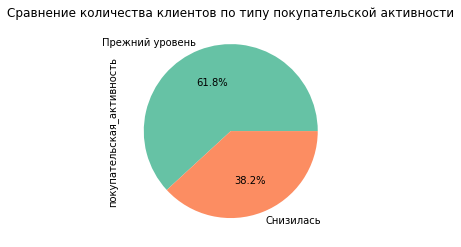

In [19]:
market_file_1['покупательская_активность'].value_counts().plot.pie(colors=sns.color_palette('Set2'),
                                                                               autopct='%1.1f%%');
plt.title('Сравнение количества клиентов по типу покупательской активности');

у 61,8% покупателей активность осталась прежней, а вот у 38,2% она снизилась. 

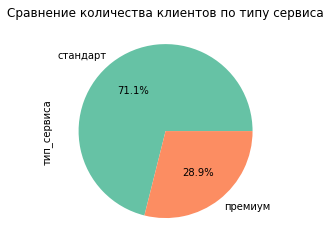

In [20]:
market_file_1['тип_сервиса'].value_counts().plot.pie(colors=sns.color_palette('Set2'), autopct='%1.1f%%');
plt.title('Сравнение количества клиентов по типу сервиса');

премиум-обслуживаение выбирает менее трети пользователей.

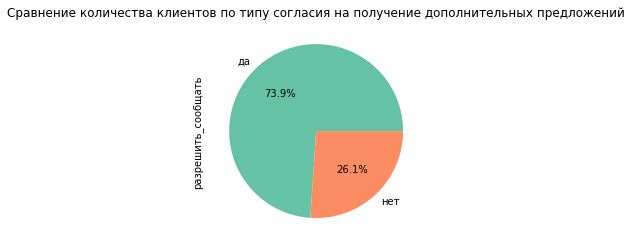

In [21]:
market_file_1['разрешить_сообщать'].value_counts().plot.pie(colors=sns.color_palette('Set2'), autopct='%1.1f%%');
plt.title('Сравнение количества клиентов по типу согласия на получение дополнительных предложений');

четверть клиентов не хочет получить дополнительные предложения. А три четверти - готовы.

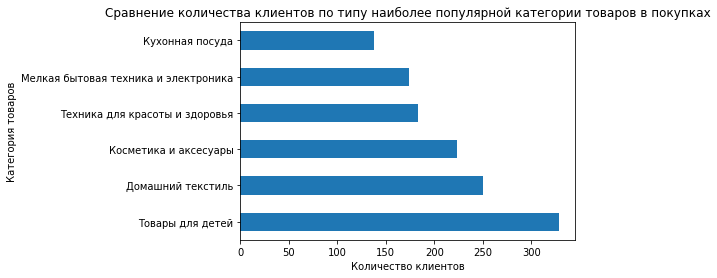

In [22]:
market_file_1['популярная_категория'].value_counts().plot.barh(figsize=(6,4));
plt.title('Сравнение количества клиентов по типу наиболее популярной категории товаров в покупках');
plt.xlabel('Количество клиентов');
plt.ylabel('Категория товаров');

среди популярных категорий в исследуемом массиве данных присутствуют только шесть категорий.

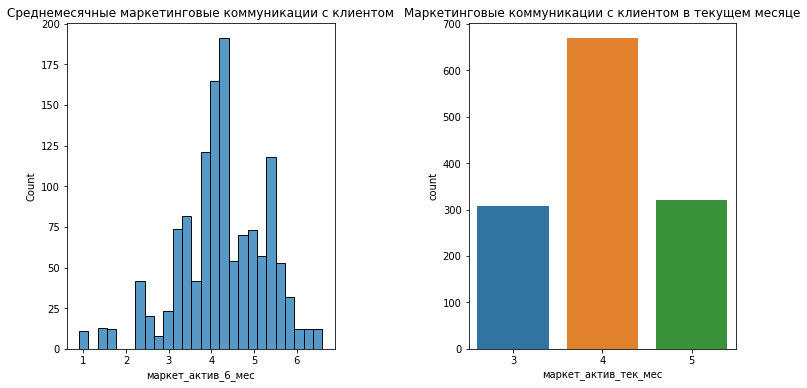

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12,6));
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.subplot(1, 2, 1)
sns.histplot(data=market_file_1, x='маркет_актив_6_мес').set(
    title = 'Cреднемесячные маркетинговые коммуникации с клиентом');
plt.subplot(1, 2, 2)
sns.countplot(data=market_file_1, x='маркет_актив_тек_мес').set(
    title = 'Маркетинговые коммуникации с клиентом в текущем месяце');

В текущем месяце клиенты получили от трех до пяти предложений о покупке. А в гистограмме полугодовой активности, где собраны данные о предложениях в среднем за месяц, есть клиенты, которые получили по 1 предложению в соответствии с этим показателем. 

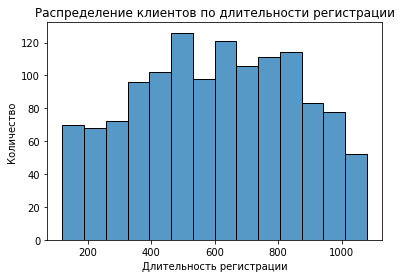

In [24]:
sns.histplot(data=market_file_1, x="длительность");
plt.title('Распределение клиентов по длительности регистрации');
plt.xlabel('Длительность регистрации');
plt.ylabel('Количество');

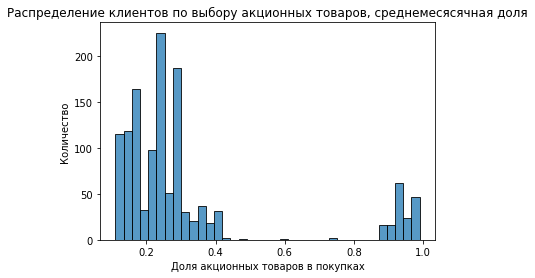

In [25]:
sns.histplot(data=market_file_1, x="акционные_покупки");
plt.title('Распределение клиентов по выбору акционных товаров, среднемесясячная доля');
plt.xlabel('Доля акционных товаров в покупках');
plt.ylabel('Количество');

У нас есть разделение на два сегмента: клиенты, 85% покупок которых товары по акции. И остальные, которые покупают не более 40% товаров по акции.

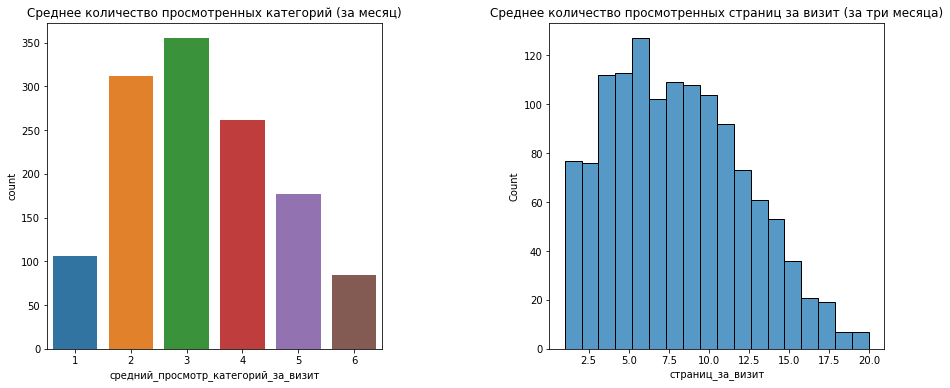

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15,6));
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.subplot(1, 2, 1)
sns.countplot(data=market_file_1, x='средний_просмотр_категорий_за_визит').set(
    title = 'Cреднее количество просмотренных категорий (за месяц)');
plt.subplot(1, 2, 2)
sns.histplot(data=market_file_1, x='страниц_за_визит').set(
    title = 'Среднее количество просмотренных страниц за визит (за три месяца)');

Мы видм биномиальное распределение со сдвигом к минимальным значениям

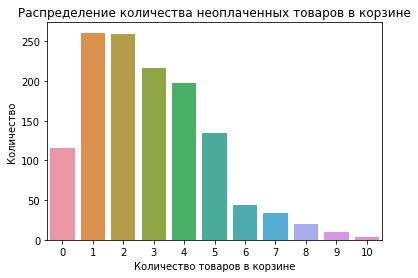

In [27]:
sns.countplot(data=market_file_1, x="неоплаченные_продукты_штук_квартал");
plt.title('Распределение количества неоплаченных товаров в корзине');
plt.xlabel('Количество товаров в корзине');
plt.ylabel('Количество');

Основная доля товаров в корзине за три месяца находится в интервале от 0 до 5 штук.

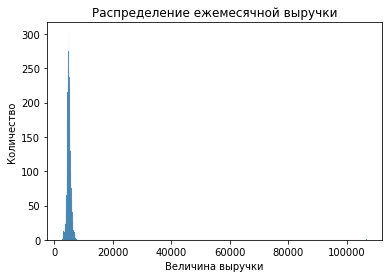

In [28]:
sns.histplot(data=market_money_1, x="Выручка");
plt.title('Распределение ежемесячной выручки');
plt.xlabel('Величина выручки');
plt.ylabel('Количество');

In [29]:
market_money_1['Выручка'].describe()

count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: Выручка, dtype: float64

Видим высокое значение-106 тысяч рублей, отбросим это значение.

In [30]:
display(len(market_money_1.query('Выручка > 8000')))
display(len(market_money_1.query('Выручка > 7000')))
market_money_1.query('Выручка > 8000')

1

35

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Ограничим данные порогом 8000 рублей в месяц

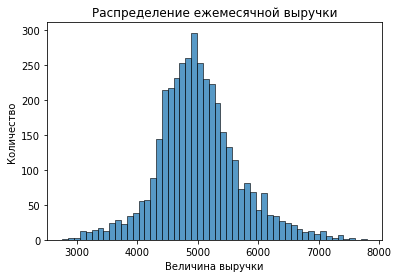

In [31]:
sns.histplot(data=market_money_1.query('Выручка < 8000'), x="Выручка");
plt.title('Распределение ежемесячной выручки');
plt.xlabel('Величина выручки');
plt.ylabel('Количество');

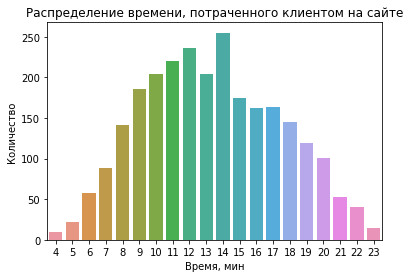

In [32]:
sns.countplot(data=market_time_1, x="минут");
plt.title('Распределение времени, потраченного клиентом на сайте');
plt.xlabel('Время, мин');
plt.ylabel('Количество');

Клиент ежемесячно тратит от 11 до 15 минут на сайте

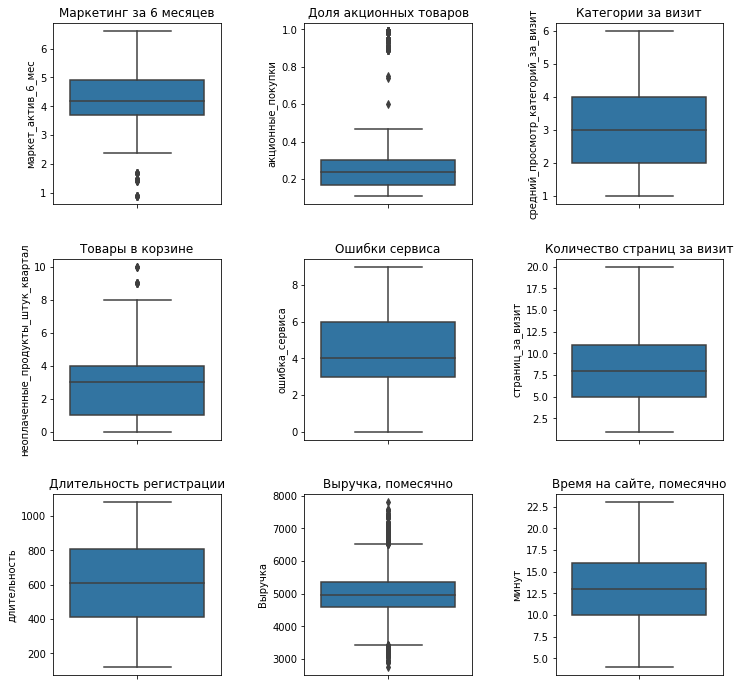

In [33]:
fig, axes = plt.subplots(3, 3, figsize=(12,12));
plt.subplots_adjust(wspace=0.5, hspace=0.3)
sns.boxplot(data=market_file_1, y='маркет_актив_6_мес', ax=axes[0, 0]).set (
    title='Маркетинг за 6 месяцев');
sns.boxplot(data=market_file_1, y='акционные_покупки', ax=axes[0, 1]).set (
    title='Доля акционных товаров');
sns.boxplot(data=market_file_1, y='средний_просмотр_категорий_за_визит', ax=axes[0, 2]).set (
    title='Категории за визит');
sns.boxplot(data=market_file_1, y='неоплаченные_продукты_штук_квартал', ax=axes[1, 0]).set (
    title='Товары в корзине');
sns.boxplot(data=market_file_1, y='ошибка_сервиса', ax=axes[1, 1]).set (
    title='Ошибки сервиса');
sns.boxplot(data=market_file_1, y='страниц_за_визит', ax=axes[1, 2]).set (
    title='Количество страниц за визит');
sns.boxplot(data=market_file_1, y='длительность', ax=axes[2, 0]).set (
    title='Длительность регистрации');
sns.boxplot(data=market_money_1.query('Выручка < 8000'), y='Выручка', ax=axes[2, 1]).set (
    title='Выручка, помесячно');
sns.boxplot(data=market_time_1, y='минут', ax=axes[2, 2]).set (
    title='Время на сайте, помесячно');

*Маркетинг за 6 месяцев:*  
основная часть данных сгруппирована в области 4-5 предложений клиентам за месяц.   
*Доля акционных товаров:*  
основная часть данных находится в области 20-30% покупок по акции. Но на гистограмме клиенты делились на две большие группы.  
*Категории за визит:*  
в основном, клиенты просматривают 2-4 категории товаров за один визит на сайт.  
*Товары в корзине:*  
в основном, клиенты могут оставлять в корзине от 1 до 4 неоплаченных товаров.  
*Ошибки сервиса:*  
в сновном пользователи сталкиваются с 3-6 ошибками сервиса.  
*Количество страниц за визит:*  
в среднем клиент успевает просмотреть от 5 до 11 страниц в интернет-магазине.  
*Длительность регистрации:*  
основная часть клиентов зарегистрирована на сайте от одного года до двух с половиной.  
*Выручка помесячно:*  
основное количество клиентов тратит в месяц в этом интернет-магазине 4500-5500 рублей.  
*Время на сайте помесячно:*  
в основном клиент тратит на сайте в месяц от 10 до 16 минут. Это довольно мало времени.

**Шаг 4. Объединение таблиц**

In [34]:
market_money_pivot = market_money_1.pivot_table(index='id', 
                                                columns='Период', values='Выручка')
market_money_pivot.head(10)

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
215354,5685.0,4503.0,5869.6
215355,3263.0,4749.0,3772.6
215356,4146.5,4433.0,4566.4
215358,3488.0,4727.0,4209.5


In [35]:
market_time_pivot = market_time_1.pivot_table(index='id', 
                                              columns='Период', values='минут')
market_time_pivot.head(10)

Период,предыдцщий_месяц,текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10
215354,11,12
215355,12,10
215356,6,7
215358,14,10


In [36]:
df_market = market_file_1.merge(market_money_pivot, on='id', how='left')
df_market = df_market.merge(market_time_pivot, on='id', how='left')

df_market.head(10)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц_x,предыдцщий_месяц,текущий_месяц_y
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
5,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
7,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
8,215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9,6


In [37]:
# Проверка на пропущенные значения
print("Пропущенные значения в данных df_market:")
display(df_market.isnull().sum())
# Проверка на дубликаты
print("\nДубликаты в данных df_market:")
display(df_market.duplicated().sum())
print("Общая информация о данных df_market:")
df_market.info()

Пропущенные значения в данных df_market:


id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
предыдущий_месяц                       0
препредыдущий_месяц                    0
текущий_месяц_x                        0
предыдцщий_месяц                       0
текущий_месяц_y                        0
dtype: int64


Дубликаты в данных df_market:


0

Общая информация о данных df_market:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская_активность            1297 non-null   object 
 2   тип_сервиса                          1297 non-null   object 
 3   разрешить_сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64 

Мы успешно выполнили задачу объеденения и проверки данных, что позволит нам провести более глубокий и точный анализ в будущем.

In [38]:
df_market.текущий_месяц_x.max()

106862.2

In [39]:
df_market.loc[df_market['id']==215380]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,предыдущий_месяц,препредыдущий_месяц,текущий_месяц_x,предыдцщий_месяц,текущий_месяц_y
29,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,6077.0,5051.0,106862.2,12,14


In [40]:
df_market = df_market.loc[df_market['id']!=215380]
df_market.shape

(1296, 18)

**Шаг 5. Корреляционный анализ**

In [41]:
# Удаление столбца 'id'
data_without_id = df_market.drop('id', axis=1)


interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц_x', 'предыдцщий_месяц', 'текущий_месяц_y']


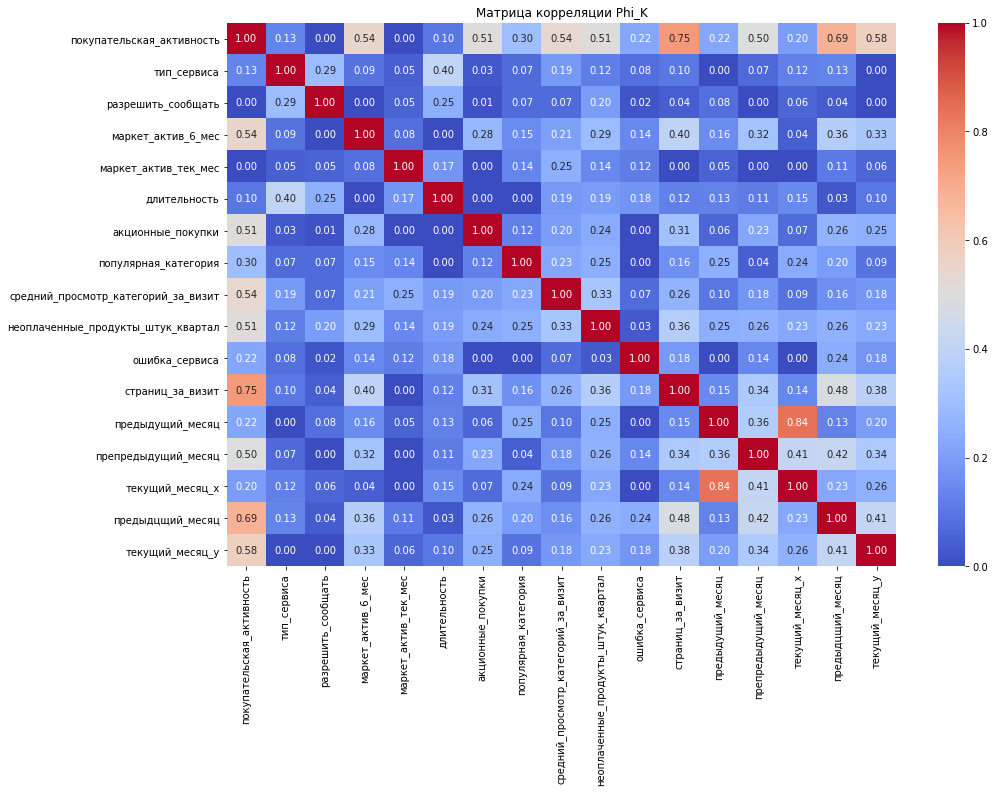

In [42]:
# Вычисление матрицы корреляции Phi_K для данных без 'id'
phik_matrix = data_without_id.phik_matrix()

# Визуализация матрицы корреляции Phi_K
plt.figure(figsize=(15, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица корреляции Phi_K")
plt.show()

Наш целевой признак - "покупательская активность".   
Наибольшее влияние на него оказывают следующие параметры: "маркет актив 6 мес", "акционные покупки", "средний просмотр категорий за визит", "неоплаченные продукты штук квартал", "страниц за визит", "предпред месяц выручка", "пред месяц время" и "текущ месяц время".  
Некоторые признаки, такие как Тип сервиса и Разрешить сообщать, имеют низкую корреляцию с покупательской активностью. Это может указывать на то, что эти признаки могут не оказывать значительного влияния на покупательскую активность.  
Однако корреляция не гарантирует причинно-следственную связь, и дополнительный анализ может быть необходим для определения важности этих признаков.  
Мультиколлинеарности в данных не отмечено 

**Шаг 6. Использование пайплайнов**

In [43]:
df_mod = df_market.drop('id', axis=1)

In [44]:
# Заменяем значения в столбце Покупательская активность
df_mod['покупательская_активность'] = df_mod['покупательская_активность'].replace({'Снизилась': 1, 'Прежний уровень': 0})

In [45]:
# Задаем параметры для разделения данных
RANDOM_STATE = 13
TEST_SIZE = 0.20

# Определение целевого признака
target = 'покупательская_активность'

# Получение списка всех признаков, за исключением целевого
features = df_mod.columns.drop(target)

# Определение числовых и текстовых признаков
num_columns = df_mod[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
ohe_columns = df_mod[features].select_dtypes(include=['object']).columns.tolist()
ord_columns = ['тип_сервиса']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_mod.drop(target, axis=1), # Независимые переменные
    df_mod[target], # Зависимая переменная
    test_size=TEST_SIZE, # Размер тестовой выборки
    random_state=RANDOM_STATE # Случайное состояние для воспроизводимости
)


ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first'))
    ]
    )
ord_pipe = Pipeline(
    [('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns),
        ('ord', ord_pipe, ord_columns),
    ], 
    remainder='passthrough'
)


pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

# создаем список словарей для каждой модели
param_grid = [
        # словарь для модели DecisionTreeClassifier()
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(2,10),
        'model__max_features': range(2,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),  'passthrough']  
    },
    
# словарь для модели LogisticRegression()    
    {
        'model': [LogisticRegression(solver='liblinear', penalty='l1', random_state=RANDOM_STATE)],
        'model__C': range(1,5),        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),'passthrough']  
    }

]

grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)
y_test_pred = grid.predict(X_test)
roc_auc = roc_auc_score(y_test, y_test_pred)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc:.4f}')
# Предсказание вероятностей классов
probabilities = grid.predict_proba(X_test)

# Извлечение вероятностей для класса 1
probabilities_one = probabilities[:, 1]

# Вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, probabilities_one)

print(f'Метрика ROC-AUC для класса 1 на тестовой выборке: {roc_auc:.4f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['тип_сервиса',
                                                   'разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('num', MinMaxScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'маркет_актив_тек_мес',
                                                   'длительность',
                                                   'акционные_покупки',
                                                   'средний_просмотр_

В результате выполнения кода, была выбрана лучшая модель и её параметры. Лучшей моделью оказалась LogisticRegression(C=1, penalty='l1', random_state=13, solver='liblinear').Эта модель была обучена на данных, предварительно обработанных с помощью OneHotEncoder для категориальных признаков и MinMaxScaler для числовых признаков..

Метрика лучшей модели на тренировочной выборке (0.9108): Это показывает, что модель хорошо обучилась на тренировочных данных и смогла уловить большую часть закономерностей в данных.

Метрика ROC-AUC на тестовой выборке (0.8750): Это значение немного ниже, чем на тренировочной выборке, что говорит о том, что модель хорошо обобщает на новых данных, даже чуть лучше, чем на тренировочных данных.

Метрика ROC-AUC вероятностей для класса 1 на тестовой выборке (0.9204): Это значение выше, чем просто метрика ROC-AUC на тестовой выборке, что говорит о том, что модель еще лучше работает, когда она оценивает вероятности классов, а не просто предсказывает метки классов.

Таким образом, выбранная модель показала хорошие результаты и может быть использована для прогнозирования покупательской активности на основе предоставленных данных.

**Шаг 7. Анализ важности признаков**

None

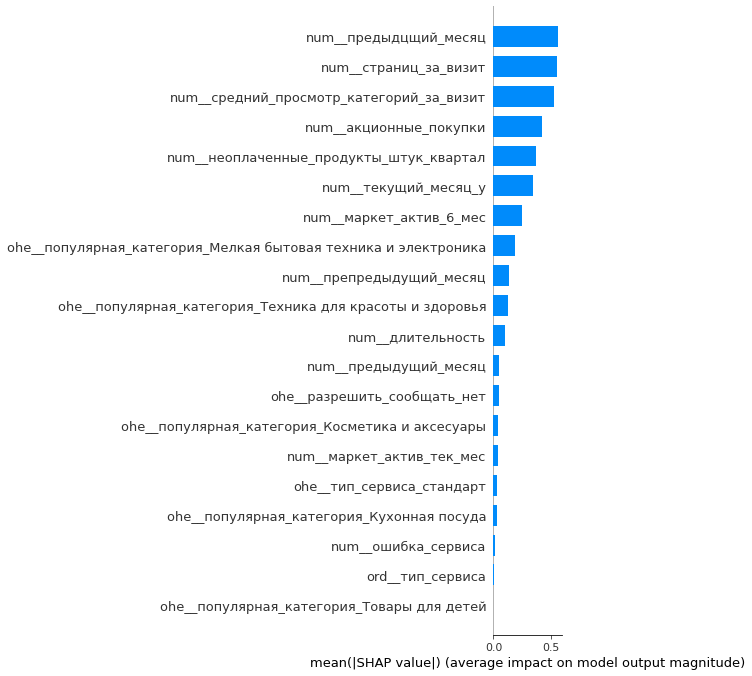

In [46]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.Explainer(grid.best_estimator_.named_steps['model'], X_train_2)
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names) 
shap_values = explainer(X_test_2) 
display(shap.summary_plot(shap_values, plot_type = 'bar', max_display = 20, show = False))

Вывод: Признаки, такие как “num_минут_предыдущий_месяц”, “num_Страниц_за_визит” и “num_Средний просмотр категории за визит”, являются наиболее значимыми, так как они имеют наибольшее влияние на покупательскую активность.

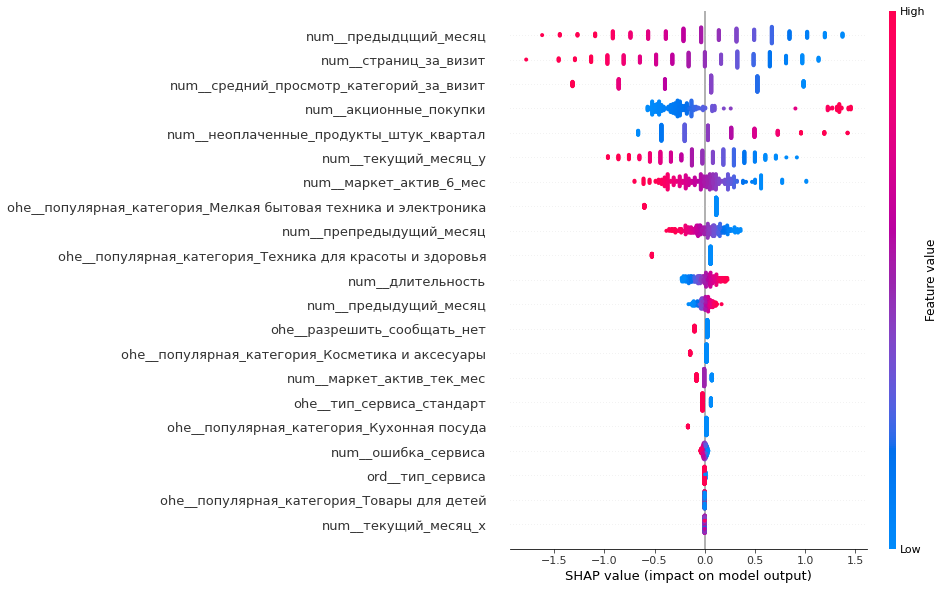

In [47]:
shap.plots.beeswarm(shap_values, max_display=300) 

Самые влиятельные признаки, которые способствуют покупательской активности, это:

"num_минут_предыдущий_месяц": Этот признак отражает, сколько времени покупатель проводил на сайте в минутах. Он имеет большое отрицательное значение SHAP, что означает, что чем больше этот признак, тем меньше шансов, что покупательская активность снизится.

"num_Страницы_за_визит": Этот признак измеряет, сколько страниц покупатель просматривал за один визит на сайт в среднем за последние 3 месяца. Он также имеет большое отрицательное значение SHAP, что говорит о том, что чем больше этот признак, тем выше покупательская активность.

"num_Средний_просмотр_категории_за_визит": Этот признак показывает, сколько категорий товаров покупатель смотрел за визит в среднем за последний месяц. Он имеет отрицательное значение SHAP, но меньше, чем у предыдущих двух признаков.

"num_Акционные покупки": Этот признак вычисляет, какая доля покупок покупателя была по акции в среднем за последние 6 месяцев. Он имеет положительное значение SHAP, что значит, что чем больше этот признак, тем больше вероятность снижения покупательской активности.

"num_Неоплаченые продукты штука квартал": Этот признак считает, сколько товаров покупатель оставлял в корзине без оплаты за последние 3 месяца. Он также имеет положительное значение SHAP, что свидетельствует о том, что чем больше этот признак, тем ниже покупательская активность.

"num_минут текущий месяц": Этот признак отображает, сколько времени покупатель проводил на сайте в минутах. Он имеет небольшое отрицательное значение SHAP, что указывает на то, что чем больше этот признак, тем выше покупательская активность.

"num_Маркет актив 6 мес": Этот признак определяет, сколько маркетинговых акций компании достигало покупателя в среднем за последние 6 месяцев. Это число включает в себя рассылки, звонки, рекламу и т.д. Он имеет отрицательное значение SHAP, что означает, что чем больше этот признак, тем выше покупательская активность.

"one_Популярная категория Мелкая бытовая техника и электроника": Этот признак показывает, какая категория товаров была самой популярной у покупателя за последние 6 месяцев. Он имеет небольшое отрицательное значение SHAP, что значит, что чем больше этот признак, тем выше покупательская активность.

num_выручка препредыдущий месяц: Этот признак измеряет, сколько денег покупатель потратил на сайте за предпредыдущий месяц. Он имеет небольшое отрицательное значение SHAP, что означает, что чем больше этот признак, тем выше покупательская активность.

Признаки с большими положительными значениями SHAP сильнее всего влияют на снижение покупательской активности, а признаки с отрицательными значениями SHAP - на сохранение покупательской активности. При разработке стратегий по работе с клиентами нужно учитывать все эти признаки.

Эти наблюдения могут помочь нам понять, какие факторы влияют на покупательскую активность клиентов, и как можно улучшить стратегию продаж. Например:

Предлагать клиентам, которые делают много акционных покупок, альтернативные товары с более высокой маржой или увеличивать цену на акционные товары.  
Снижать количество неоплаченных товаров в корзине, например, отправляя напоминания, предлагая бесплатную доставку или гарантию возврата.  
Увеличивать количество маркетинговых коммуникаций с клиентами, которые редко посещают сайт или мало тратят, чтобы повысить их лояльность и интерес к товарам.  
Анализировать, какие категории товаров наиболее популярны у клиентов, и оптимизировать ассортимент, ценообразование и продвижение этих категорий.

**Шаг 8. Сегментация покупателей**

Будем изучать сегмент "Пассивные скидочники", может быть определен следующим образом:

"num_минут_предыдущий_месяц": Покупатели в этой группе проводят меньше времени на сайте, чем другие. Это может быть связано с тем, что они редко ищут товары, не связанные со скидками.

"num_Страницы_за_визит": Они просматривают меньше страниц за визит, что указывает на их фокусировку на конкретных товарах или категориях, скорее всего, со скидками.

"num_Средний_просмотр_категории_за_визит": Они просматривают меньше категорий товаров за визит, что также указывает на их узкую фокусировку на определенных товарах или категориях.

"num_Акционные покупки": Большая часть их покупок совершается по акции, что подтверждает их стремление к экономии.

"num_Неоплаченые продукты штука квартал": Они часто оставляют товары в корзине без оплаты, возможно, ожидая снижения цены.

Эти покупатели могут быть ценными для бизнеса, поскольку они могут быть мотивированы к покупке при предложении скидок или акций. Однако важно учесть, что их покупательская активность может быть ниже, чем у других групп покупателей. Это может потребовать специальных маркетинговых стратегий.

In [48]:
# объединение данных
df_market = df_market.merge(money, on='id', how='left')

In [49]:
df_market.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [50]:
# Определение сегмента "Пассивные скидочники"
passive_discounters = df_market[
    (df_market['предыдцщий_месяц'] < df_market['предыдцщий_месяц'].mean()) &
    (df_market['страниц_за_визит'] < df_market['страниц_за_визит'].mean()) &
    (df_market['средний_просмотр_категорий_за_визит'] < df_market['средний_просмотр_категорий_за_визит'].mean()) &
    (df_market['акционные_покупки'] > df_market['акционные_покупки'].mean()) &
    (df_market['неоплаченные_продукты_штук_квартал'] > df_market['неоплаченные_продукты_штук_квартал'].mean())
]

print(f'Создан сегмент "Пассивные скидочники" с {len(passive_discounters)} покупателями.')

Создан сегмент "Пассивные скидочники" с 119 покупателями.


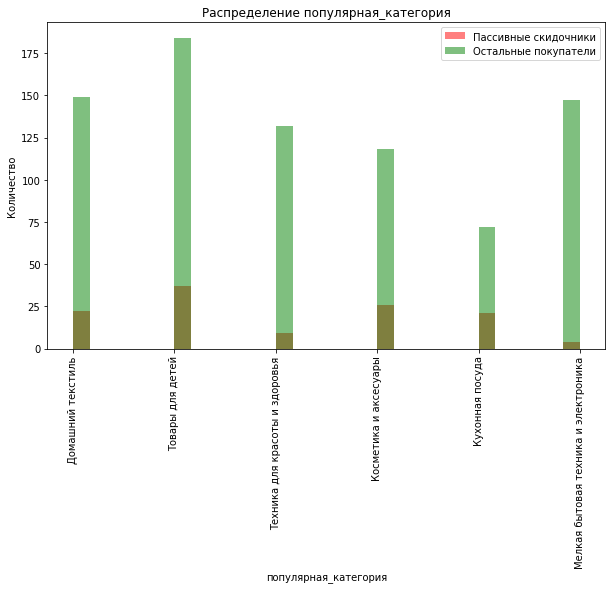

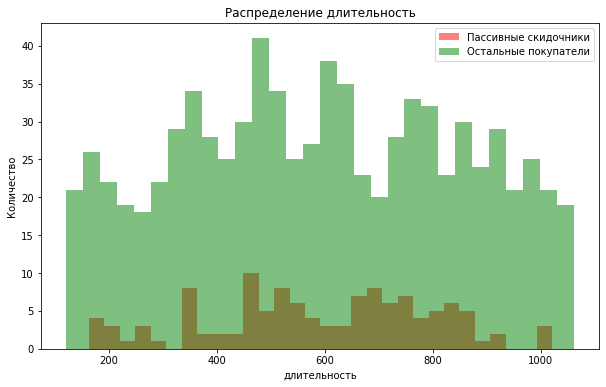

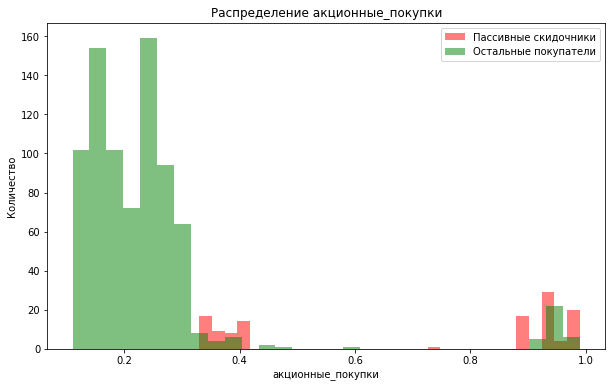

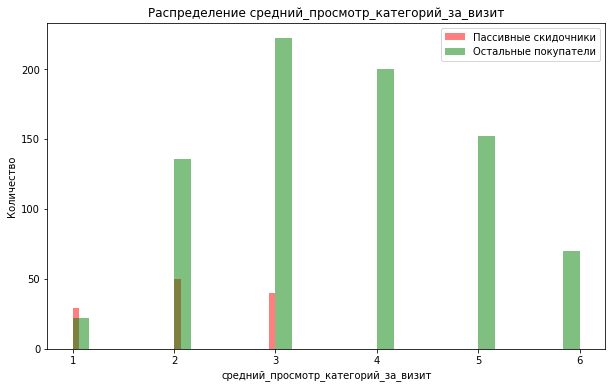

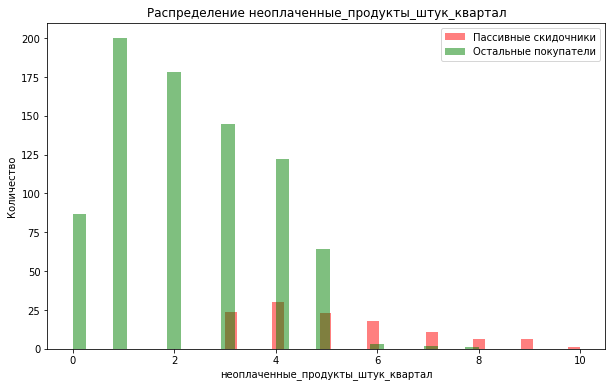

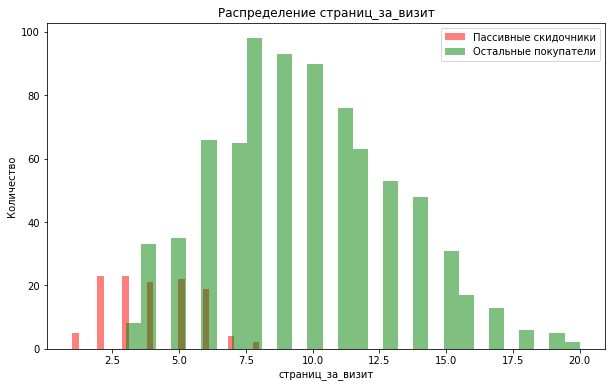

KeyError: 'предыдущий_месяц'

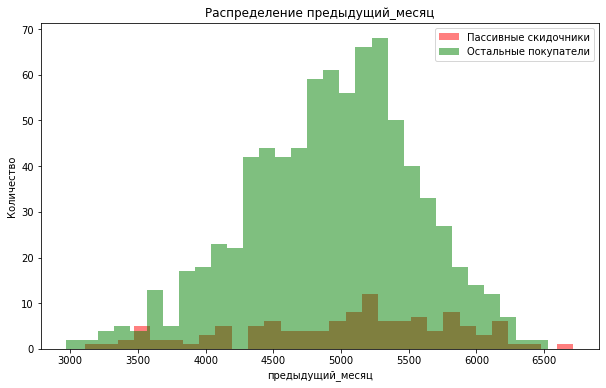

In [51]:
# Остальные покупатели, у которых активность не снизилась
other_customers = df_market[df_market['покупательская_активность'] != 'Снизилась']

# Анализ покупательской активности
activity_columns = (['популярная_категория', 'длительность', 
                     'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
                     'неоплаченные_продукты_штук_квартал', 'страниц_за_визит', 
                     'предыдущий_месяц','препредыдущий_месяц', 
                     'текущий_месяц_x', 
                     'текущий_месяц_y', 'разрешить_сообщать','Прибыль']
                   )
activity_data = passive_discounters[activity_columns]

# Визуализация покупательской активности
for column in activity_columns:
    plt.figure(figsize=(10, 6))
    
    # Пассивные скидочники
    plt.hist(passive_discounters[column], bins=30, alpha=0.5, color='r', label='Пассивные скидочники')
    
    # Остальные покупатели
    plt.hist(other_customers[column], bins=30, alpha=0.5, color='g', label='Остальные покупатели')
    
    
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.legend()
    
    # Поворот названий категорий на вертикальные оси
    if market_file[column].dtype == 'object':
        plt.xticks(rotation='vertical')
    
    plt.show()

In [ ]:
# Добавление общих столбцов
passive_discounters['Общая_выручка_3_месяца'] = passive_discounters[['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц_x']].sum(axis=1)
other_customers['Общая_выручка_3_месяца'] = other_customers[['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц_x']].sum(axis=1)

passive_discounters['Общие_минуты_2_месяца'] = passive_discounters[['предыдцщий_месяц', 'текущий_месяц_y']].sum(axis=1)
other_customers['Общие_минуты_2_месяца'] = other_customers[['предыдцщий_месяц', 'текущий_месяц_y']].sum(axis=1)

# Обновление списка столбцов для анализа
activity_columns += ['Общая_выручка_3_месяца', 'Общие_минуты_2_месяца']

# Создаем пустой DataFrame для хранения результатов
comparison_table = pd.DataFrame()

# Проходим по каждому столбцу в данных
for column in activity_columns:
    # Если тип данных столбца - object, то это категориальные данные
    if passive_discounters[column].dtype == 'object':
        comparison_table.loc['Мода (Пассивные скидочники)', column] = passive_discounters[column].mode()[0]
        comparison_table.loc['Мода (Остальные покупатели)', column] = other_customers[column].mode()[0]
    else:
        # Иначе это числовые данные
        comparison_table.loc['Медиана (Пассивные скидочники)', column] = passive_discounters[column].median()
        comparison_table.loc['Медиана (Остальные покупатели)', column] = other_customers[column].median()

# Выводим таблицу сравнения
# Транспонирование таблицы для удобства просмотра
display(comparison_table.transpose())

На основе представленных данных, можно сделать следующие выводы:

Акционные покупки: Пассивные скидочники в среднем совершают больше акционных покупок (0.9 против 0.21 у остальных покупателей). 

Длительность: Средняя длительность посещения сайта примерно одинакова для обеих групп покупателей (598 минут у пассивных скидочников против 590 минут у остальных покупателей).

Неоплаченные продукты: Пассивные скидочники в среднем оставляют больше неоплаченных продуктов (5.0 против 2.0 у остальных покупателей).

Общая выручка за 3 месяца: Общая выручка за последние три месяца примерно одинакова для обеих групп покупателей (15145.7 у пассивных скидочников против 15107.75 у остальных покупателей).

Общее время на сайте за 2 месяца: Остальные покупатели в среднем проводят на сайте больше времени (30.0 минут против 20.0 минут у пассивных скидочников).

Популярная категория: Для обеих групп покупателей самой популярной категорией являются товары для детей.

Прибыль: Средняя прибыль от остальных покупателей немного выше, чем от пассивных скидочников (4.04 против 3.92).

Разрешение на рассылку: Большинство покупателей из обеих групп разрешили рассылку.

Средний просмотр категорий за визит: Остальные покупатели в среднем просматривают больше категорий за визит (4.0 против 2.0 у пассивных скидочников).

Страниц за визит: Остальные покупатели в среднем просматривают больше страниц за визит (10.0 против 4.0 у пассивных скидочников).

Вот несколько предложений по работе с сегментом "Пассивные скидочники" для увеличения покупательской активности:

Увеличение количества акций: Поскольку этот сегмент покупателей часто совершает акционные покупки, можно увеличить количество акций и скидок, чтобы стимулировать их активность.

Оптимизация времени на сайте: Учитывая, что эти покупатели проводят меньше времени на сайте, можно оптимизировать пользовательский интерфейс и упростить процесс покупки, чтобы они могли быстрее находить то, что им нужно.

Улучшение системы рекомендаций: Поскольку эти покупатели часто просматривают меньше категорий за визит, можно улучшить систему рекомендаций, чтобы предлагать им товары, которые могут их заинтересовать.

Работа с неоплаченными продуктами: Учитывая, что эти покупатели часто оставляют неоплаченные продукты, можно предложить им специальные скидки или напоминания о них, чтобы стимулировать их к покупке.

Персонализированные предложения: Используйте данные о популярных категориях для создания персонализированных предложений и рекламных акций, которые могут привлечь внимание этих покупателей.

Сообщения и уведомления: Поскольку большинство покупателей из этого сегмента разрешили рассылку, можно использовать этот канал для отправки персонализированных предложений и напоминаний о неоплаченных продуктах.

**Шаг 9. Общий вывод**

Задача: Разработать решение для интернет-магазина «В один клик», которое поможет увеличить покупательскую активность постоянных клиентов через персонализированные предложения. Для этого необходимо предсказать вероятность снижения покупательской активности клиента в следующие три месяца, выделить сегменты покупателей и разработать для них персонализированные предложения.

Исходные данные и предобработка: Данные состоят из четырех наборов данных: Market File, Market Money, Market Time и Money. В ходе предобработки были исправлены опечатки, удалены аномалии, объединены таблицы и проведен исследовательский анализ данных.

Поиск лучшей модели: Для поиска лучшей модели были использованы четыре алгоритма классификации: логистическая регрессия, k-ближайших соседей, дерево решений и метод опорных векторов. Для каждого алгоритма была проведена кросс-валидация и подбор гиперпараметров. Качество моделей было оценено по метрике ROC-AUC.

Лучшая модель: Логистическая регрессия с C=1, penalty='l1', random_state=13, solver='liblinear' ROC-AUC равным 0.90 стала лучшей моделью. Она выявила ключевые факторы покупательской активности: время на сайте, количество просмотренных страниц и категорий, доля акционных покупок, количество неоплаченных товаров, количество маркетинговых акций, популярная категория товаров и сумма потраченных денег.

Сегмент “Пассивные скидочники” характеризуется меньшим временем на сайте, узкой фокусировкой на товарах со скидками и большим количеством неоплаченных товаров. Для стимулирования их активности предлагается увеличить количество акций, оптимизировать интерфейс сайта, улучшить систему рекомендаций, работать с неоплаченными товарами и использовать рассылку для отправки персонализированных предложений